In [1]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import plot_loss
from torch import optim
from tqdm.notebook import trange

from memflow.read_data.dataset_all import DatasetCombined
from memflow.unfolding_network.conditional_transformer import ConditioningTransformerLayer

In [2]:
import sys

In [3]:
sys.path

['/afs/cern.ch/user/a/adpetre/public/MEMFlow/notebooks/unfolding_flow',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos9-gcc11-opt/lib/python3.9/site-packages/itk',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos9-gcc11-opt/python',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos9-gcc11-opt/lib',
 '',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos9-gcc11-opt/lib/python3.9/site-packages',
 '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos9-gcc11-opt/lib/python39.zip',
 '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos9-gcc11-opt/lib/python3.9',
 '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos9-gcc11-opt/lib/python3.9/lib-dynload',
 '/afs/cern.ch/user/a/adpetre/public/myenv/lib/python3.9/site-packages',
 '/afs/cern.ch/user/a/adpetre/public/zuko',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos9-gcc11-opt/lib/python3.9/site-packages/IPython/extensions',
 '/afs/cern.ch/user/a/adpetre/.ipython

In [4]:
dataset = DatasetCombined("../../../dataset/v7/")
batch_size = 512
# Read data
dataiterator = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

jets file already exists
lepton_reco file already exists
met file already exists
boost file already exists
partons file already exists
lepton_partons file already exists
boost file already exists
H_thad_tlep_ISR file already exists
H_thad_tlep_ISR_cartesian file already exists


In [5]:
(mask_partons, data_partons, 
mask_lepton_partons, data_lepton_partons, 
mask_boost_parton, data_boost_parton, 
data_intermediate, data_intermediate_cartesian,
data_ps, data_ps_detjacinv, 
mask_lepton, data_lepton, mask_jets,
data_jets,mask_met, data_met,
mask_boost_reco,data_boost_reco) =  next(iter(dataiterator))

(array([197.,  43.,  32.,  13.,   8.,  11.,  15.,   9.,   6.,   4.,   5.,
          2.,   2.,   5.,   5.,   6.,   5.,   6.,   3.,   7.,   0.,   0.,
          3.,   2.,   3.,   1.,   1.,   1.,   0.,   1.,   1.,   1.,   3.,
          1.,   1.,   0.,   3.,   2.,   0.,   0.,   1.,   2.,   2.,   0.,
          1.,   0.,   2.,   4.,   1.,   1.,   0.,   0.,   2.,   2.,   0.,
          1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   3.,   0.,   0.,   0.,   0.,   3.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   2.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.]),
 array([0.0e+00, 1.0e-04, 2.0e-04, 3.0e-04, 4.0e-04, 5.0e-04, 6.0e-04,
        7.0e-04, 8.0e-04, 9.0e-04, 1.0e-03, 1.1e-03, 1.2e-03, 1.3e-03,
        1.4e-03, 1.5e-03, 1.6e-03, 1.7e-03, 1.8e-03, 1.9e-03, 2.0e-03,
        2.1e-03, 2.2e-03, 2.3e-03, 2.4e-03, 2.5e-03, 2.6e-03, 2.7e-03,
        2.8e-03, 2.9e-03, 3.0e-03,

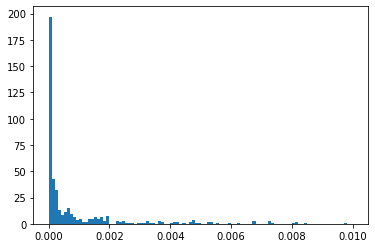

In [6]:
plt.hist(data_ps_detjacinv.flatten().numpy(), bins=100, range=(0, 0.01))

In [7]:
# Initialize Transformer Layer
transformer = ConditioningTransformerLayer(jets_features=data_jets.size(2), 
                                           lepton_features=data_lepton.size(2), 
                                           out_features=32, nhead=8, no_layers=3)

# Obtain conditional_input from transformer (pass batches and masks to `forward` method)
conditional_input = transformer.forward(data_jets, data_lepton, data_met,
                                        data_boost_reco, mask_jets, 
                                        mask_lepton, mask_met, mask_boost_reco)

RuntimeError: Device index must not be negative

In [ ]:
plt.hist2d(conditional_input.detach().numpy()[:, 0], 
           conditional_input.detach().numpy()[:, 1], bins=100) ;

In [ ]:
plt.figure(figsize=(8,8), dpi=150)
plt.imshow(conditional_input.T.detach().numpy(), cmap="bwr")

# Setup the flow

In [4]:
import zuko

In [5]:
from zuko.flows import TransformModule, SimpleAffineTransform
from zuko.distributions import BoxUniform

In [ ]:
from tensorboardX import SummaryWriter

writer = SummaryWriter()

In [6]:
def build_flow(nfeatures=10, ncond=32, ntransforms=4, hidden_mlp=[32]*3, bins=8, autoregressive=True):
    
    flow = zuko.flows.NSF(features=nfeatures,
                          context=ncond, 
                          transforms=ntransforms, 
                          bins=bins, 
                          hidden_features=hidden_mlp, 
                          randperm=False,
                          base=BoxUniform,
                          base_args=[torch.ones(nfeatures)*(-1),torch.ones(nfeatures)], 
                          univariate_kwargs={"bound": 1 }, # Keeping the flow in the [-1,1] box.
                          passes= 2 if not autoregressive else nfeatures)

    flow.transforms.insert(0, SimpleAffineTransform(0*torch.ones(nfeatures),1*torch.ones(nfeatures),
                                                 -1*torch.ones(nfeatures), 1*torch.ones(nfeatures)))
    
    return flow

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [10]:
fl1 = build_flow(nfeatures=10,
                 ncond=34, 
                 ntransforms=6, 
                 hidden_mlp=[64]*3, 
                 bins=10, 
                 autoregressive=False)

cond_transformer = ConditioningTransformerLayer(jets_features=data_jets.size(2), 
                                           lepton_features=data_lepton.size(2), 
                                           out_features=32, nhead=8, no_layers=3)

print(f"parameters, {count_parameters(fl1)}")

parameters, 180320


In [12]:
ps_samples = fl1(conditional_input).sample((100, ))

NameError: name 'conditional_input' is not defined

In [ ]:
%%timeit
ps_samples = fl1(conditional_input).sample((1, ))

In [ ]:
%%timeit
ps_prob = fl1(conditional_input).log_prob(data_ps)

In [ ]:
plt.hist(ps_prob.detach().log().numpy(), bins=50);

## Training loop

In [81]:
nepochs = 5
lr_init = 0.00006 # 33 best - peste 500, apoi 13 bun
batch_size = 256


In [82]:
cuda = torch.device('cuda')
data_cuda = DatasetCombined("../../../dataset/v7/", dev=cuda, dtype=torch.float64)
# Read data
dataiterator = DataLoader(data_cuda, batch_size=batch_size, shuffle=True, drop_last=True)

(mask_partons, data_partons, 
mask_lepton_partons, data_lepton_partons, 
mask_boost_parton, data_boost_parton, 
data_intermediate, data_intermediate_cartesian,
data_ps, data_ps_detjacinv, 
mask_lepton, data_lepton, mask_jets,
data_jets,mask_met, data_met,
mask_boost_reco,data_boost_reco) =  next(iter(dataiterator))

print(data_partons.dtype)

jets file already exists
lepton_reco file already exists
met file already exists
boost file already exists
partons file already exists
lepton_partons file already exists
boost file already exists
H_thad_tlep_ISR file already exists
H_thad_tlep_ISR_cartesian file already exists
NAN: M
NAN: K_t
torch.float64


In [83]:
#dataiterator = DataLoader(data_cuda, batch_size=batch_size, shuffle=True, drop_last=True)
dataiterator = DataLoader(data_cuda, batch_size=batch_size, shuffle=False, drop_last=True)

In [84]:
class MyEnsemble(nn.Module):
    def __init__(self, cond_transformer, flow):
        super(MyEnsemble, self).__init__()
        self.cond_transformer = cond_transformer
        self.flow = flow
        
    def forward(self, data):
        
        
        (mask_partons, data_partons, 
        mask_lepton_partons, data_lepton_partons, 
        mask_boost_parton, data_boost_parton, 
        data_intermediate, data_intermediate_cartesian,
        data_ps, data_ps_detjacinv, mask_lepton, data_lepton, mask_jets,
        data_jets,mask_met, data_met,
        mask_boost_reco,data_boost_reco) =  data

        cond_X = self.cond_transformer(data_jets,
                                    data_lepton,
                                      data_met,
                                      data_boost_reco, 
                                      mask_jets, 
                                      mask_lepton, 
                                      mask_met, 
                                      mask_boost_reco)

        logp_g =  self.flow(cond_X).log_prob(data_ps)  + data_ps_detjacinv.log() # Be careful, we are probably missing the rambo jacobian

        return logp_g, cond_X

In [85]:
cond_transformer = ConditioningTransformerLayer(jets_features=data_jets.size(2), 
                                           lepton_features=data_lepton.size(2), 
                                           out_features=32, nhead=4, no_layers=4, dtype=torch.float64).to("cuda")


flow = build_flow(nfeatures=10,
                 ncond=34, 
                 ntransforms=4, #6 
                 hidden_mlp=[128]*3, 
                 bins=16, 
                 autoregressive=True).to("cuda")

model = MyEnsemble(cond_transformer, flow)


optimizer = optim.Adam(list(model.parameters()) , lr=lr_init)

#decay = 0.01
#fcn = lambda step: 1./(1. + decay*step)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=fcn)

plotter = plot_loss.LossPlotter(["loss_epoch","loss"])

print(f"parameters flow:{count_parameters(flow)}, parameters conditioner: {count_parameters(cond_transformer)}")
print(f"parameters total:{count_parameters(model)}")

parameters flow:397676, parameters conditioner: 550605
parameters total:948281


In [86]:
len(dataiterator)

2226

In [87]:
torch.autograd.set_detect_anomaly(True)

In [88]:
scaler = torch.cuda.amp.GradScaler()

# TO TALK

## 1. Organizatorial
A) June and free dates

B) port forwarding - ssh connection refused



## 2. Event: 723 and nan in logp_g and Event: 723 and nan in logp_g
nan and inf in logp_g but no problem when backward() is called

Should I look in rambo to see where i get nan?

## 3. float32 instead of float64 and use gradscaler? speedup on gpu


In [90]:
for e in trange(0, nepochs, desc="Epoch"):
    
    sum_loss = 0.
    N = len(dataiterator)
    t = trange(0, len(dataiterator), batch_size, desc="Batch")
    
    for i, data in enumerate(dataiterator):
        
        #print("")
        if i % 100 == 0:
            print(i)
        #print(i)
        optimizer.zero_grad()
        
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            logp_g, cond_X = model(data)

            #if torch.isnan(logp_g).any():
            #    print(f"Batch: {i} and nan in logp_g")
            #if torch.isinf(logp_g).any():
            #    print(f"Batch: {i} and inf in logp_g")

            #logp_g = torch.nan_to_num(logp_g, posinf=25, 
            #                          neginf=-25, nan=0.3)

            logp_g = torch.nan_to_num(logp_g, posinf=25, neginf=-25)

            loss =  -logp_g.nanmean()
        #print(torch.isnan(loss))
        
        # Scales the loss for autograd.grad's backward pass, producing scaled_grad_params
        #scaled_grad_params = torch.autograd.grad(outputs=scaler.scale(loss),
        #                                         inputs=model.parameters(),
        #                                         create_graph=True)

        # Creates unscaled grad_params before computing the penalty. scaled_grad_params are
        # not owned by any optimizer, so ordinary division is used instead of scaler.unscale_:
        #inv_scale = 1./scaler.get_scale()
        #grad_params = [p * inv_scale for p in scaled_grad_params]
        
        #grad_norm = 0
        #for grad in grad_params:
        #    grad_norm += grad.pow(2).sum()
        #grad_norm = grad_norm.sqrt()
        #loss = loss + grad_norm
        
        #print(logp_g.isnan().sum(),logp_g.isinf().sum(), loss.item(),  logp_g)
        #loss.backward()
        
        scaler.scale(loss).backward()
        
        scaler.unscale_(optimizer)
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.28)
        
        #optimizer.step() 
        scaler.step(optimizer)
        sum_loss += loss.item()
        scaler.update()
        
        writer.add_scalars('profiling/', {str(lr_init) + '_loss': loss.item()}, i)

        #plotter.on_epoch_end({"loss": loss.item()})
        #t.set_description(f"{loss.item():.4f}", refresh=True)
    #plotter.on_epoch_end({"loss_epoch":sum_loss/N})
    writer.add_scalars('profiling/', {str(lr_init) + '_lossEpoch': sum_loss/N}, e)

writer.close()
#     with torch.no_grad():
#         out = flow(Y_scaled[0:30000]).sample((1, )).squeeze(0)
#         plt.hist2d(out[:,0].numpy(), 
#                    Y_scaled[0:30000,0].numpy(), 
#                    bins=100,cmap="inferno", cmin=1, norm=LogNorm() );
#         plt.xlabel("Pz generated")
#         plt.ylabel("Pz reco (conditioning)")
        
#         # plt.hist2d(out[:,0].numpy(), out[:,1].numpy(),
#         #    bins=100, cmap="inferno", cmin=1, norm=LogNorm());
        
#         plt.show()
#         plt.close()


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/9 [00:00<?, ?it/s]

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200


Batch:   0%|          | 0/9 [00:00<?, ?it/s]

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200


Batch:   0%|          | 0/9 [00:00<?, ?it/s]

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200


Batch:   0%|          | 0/9 [00:00<?, ?it/s]

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200


Batch:   0%|          | 0/9 [00:00<?, ?it/s]

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200


In [138]:
x = torch.tensor([[torch.inf, 1, 2], [1, 2, 3]])
print(x.mean())

tensor(inf)


# debug for gluon ISR

In [83]:
from memflow.phasespace.phasespace import PhaseSpace

In [84]:
def get_PS_intermediateParticles(data_boost, data_higgs_t_tbar_ISR_cartesian):
    E_CM = 13000
    phasespace = PhaseSpace(E_CM, [21, 21], [25, 6, -6, 21], dev="cpu")

    incoming_p_boost = data_boost
    x1 = (incoming_p_boost[:, 0, 0] + incoming_p_boost[:, 0, 3]) / E_CM
    x2 = (incoming_p_boost[:, 0, 0] - incoming_p_boost[:, 0, 3]) / E_CM
    ps, detjinv = phasespace.get_ps_from_momenta(
                data_higgs_t_tbar_ISR_cartesian, x1, x2)
    return ps, detjinv

In [85]:
dataset = DatasetCombined("../../../dataset/v7/")
batch_size = 8
# Read data
dataiterator_cpu = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

jets file already exists
lepton_reco file already exists
met file already exists
boost file already exists
partons file already exists
lepton_partons file already exists
boost file already exists
H_thad_tlep_ISR file already exists
H_thad_tlep_ISR_cartesian file already exists
NAN: M
NAN: K_t
NAN: r


In [90]:
for i, data in enumerate(dataiterator_cpu):
    (mask_partons, data_partons, 
    mask_lepton_partons, data_lepton_partons, 
    mask_boost_parton, data_boost_parton, 
    data_intermediate, data_intermediate_cartesian,
    data_ps, data_ps_detjacinv, mask_lepton, data_lepton, mask_jets,
    data_jets,mask_met, data_met,
    mask_boost_reco,data_boost_reco) =  data
    
    #data_ps_new, det = get_PS_intermediateParticles(data_boost_parton, data_intermediate_cartesian)
    data_ps_new = data_ps
    nan_mask = torch.isnan(data_ps_new)
    
    nan_mask1 = torch.any(nan_mask, 1).unsqueeze(1)
    
    if torch.isinf(data_ps_new).any():
        print(i)
        print("INF IN DATA_PS_NEW")
    if torch.isnan(data_ps_new).any():
        print("NAN IN DATA_PS_NEW")
        
        print(nan_mask1.shape)
        
        print(data_boost_parton.shape)
        
        print(data_intermediate_cartesian[:, :].shape)
        
        partons_nan = torch.masked_select(data_boost_parton.squeeze(), nan_mask1)
        #data_intermediate_nan = torch.masked_select(data_intermediate_cartesian[:], nan_mask1)
        data_intermediate_nan = data_intermediate_cartesian[nan_mask1.squeeze(), :, :]
        
        print(data_boost_parton)
        print(partons_nan)
        
        print(data_intermediate_cartesian)
        print(data_intermediate_nan[0, 3] > 0)
        
        break

NAN IN DATA_PS_NEW
torch.Size([8, 1])
torch.Size([8, 1, 4])
torch.Size([8, 4, 4])
tensor([[[ 2135.7881,     0.0000,     0.0000, -1817.8101]],

        [[ 1466.0607,     0.0000,     0.0000,  1003.2769]],

        [[  582.5338,     0.0000,     0.0000,   171.6719]],

        [[  751.0691,     0.0000,     0.0000,   220.2215]],

        [[ 1373.0278,     0.0000,     0.0000,   766.3307]],

        [[  683.7306,     0.0000,     0.0000,   311.5125]],

        [[ 1509.4777,     0.0000,     0.0000,  -964.1247]],

        [[  662.1027,     0.0000,     0.0000,   289.0043]]])
tensor([1466.0607,    0.0000,    0.0000, 1003.2769])
tensor([[[ 301.5101,   48.4281, -202.1231, -179.1210],
         [ 285.0597,  -43.9560, -183.9457, -125.0523],
         [ 472.1206,   23.6505,  333.5321,  285.2115],
         [  62.5393,  -28.1222,   52.5388,   18.9732]],

        [[ 334.0385,  230.2855,  -83.6047,  189.5668],
         [ 413.5067,  -80.9208,  -66.9064, -360.3033],
         [ 321.4594, -149.3759,  150.5072,  1

In [90]:
n = 4
P = data_intermediate_nan
boostVector_t = partons_nan
masses_t = torch.tensor([125, 173, 173, 0])

def square_t(inputt):
    if inputt.shape[1] == 4 or inputt.shape[0] == 4:
        return dot_t(inputt, inputt)
    else:

        return torch.sum(inputt * inputt, -1)
    
def dot_t(inputa, inputb):
    """Dot product for four vectors"""
    return (
        inputa[:, 0] * inputb[:, 0]
        - inputa[:, 1] * inputb[:, 1]
        - inputa[:, 2] * inputb[:, 2]
        - inputa[:, 3] * inputb[:, 3]
    )

def boost_t(inputt, boost_vector, gamma=-1.0):
    """Transport inputt into the rest frame of the boost_vector in argument.
    This means that the following command, for any vector p=(E, px, py, pz)
        boost_t(p,-boostVector(p))
    returns to (M,0,0,0).
    Version for a single phase pace point
    """

    b2 = square_t(boost_vector)
    if gamma < 0.0:
        gamma = 1.0 / torch.sqrt(1.0 - b2)
    inputt_space = inputt[:, 1:]

    bp = torch.sum(inputt_space * boost_vector, -1)

    gamma2 = torch.where(b2 > 0, (gamma - 1.0) / b2, torch.zeros_like(b2))

    factor = gamma2 * bp + gamma * inputt[:, 0]

    inputt_space += factor.unsqueeze(1) * boost_vector

    inputt[:, 0] = gamma * (inputt[:, 0] + bp)

    return inputt

def boostVector_t(inputt):

    if torch.min(inputt[:, 0]) <= 0.0 or torch.min(square_t(inputt)) < 0.0:
        print("Invalid boost")

    return inputt[:, 1:] / inputt[:, 0].unsqueeze(1)

def rho2_t(inputt):
    """Compute the radius squared. Vectorized."""

    return torch.sum(inputt[:, 1:] * inputt[:, 1:], -1)

In [95]:
M = torch.tensor(
            [0.0] * n, requires_grad=False, dtype=torch.double, device=P.device
        )
M = torch.unsqueeze(M, 0).repeat(P.shape[0], 1)
K_t = M.clone()
Q = torch.zeros_like(P)
Q[:, -1] = P[:, -1]  # Qn = pn

# intermediate mass
for i in range(n, 0, -1):
    j = i - 1
    M[:, j] = torch.sqrt(square_t(torch.sum(P[:, j:n], axis=1)))
    # Remove the final masses to convert back to K
    K_t[:, j] = M[:,j] - torch.sum(masses_t[j:])

# output [0,1] distributed numbers
r = torch.zeros(P.shape[0], 3*n-4)

In [96]:
for i in range(n, 1, -1):
    j = i - 1  # index for 0-based tensors
    # in the direct algo the u are squared.
    u = (K_t[:, j] / K_t[:, j - 1]) ** 2

    r[:, j - 1] = (n + 1 - i) * (torch.pow(u, (n - i))) - (n - i) * (
        torch.pow(u, (n + 1 - i))
    )
    print(r)

    Q[:, j - 1] = Q[:, j] + P[:, j - 1]

    boost_t(P[:, j - 1], -boostVector_t(Q[:, j - 1]))

    r[:, n - 5 + 2 * i - 1] = (
        (P[:, j - 1, 3] / torch.sqrt(rho2_t(P[:, j - 1]))) + 1
    ) / 2
            # phi= tan^-1(Py/Px)
    phi = torch.atan(P[:, j - 1, 2] / P[:, j - 1, 1])
            # Fixing phi depending on X and y sign
            # 4th quandrant  (px > 0, py < 0)
    deltaphi = torch.where(
        (P[:, j - 1, 2] < 0) & (P[:, j - 1, 1] > 0), 2 * torch.pi, 0.0
    )
            # 2th and 3th quadratant  (px < 0, py whatever)
    deltaphi += torch.where((P[:, j - 1, 1] < 0), torch.pi, 0.0)
    phi += deltaphi
    r[:, n - 4 + 2 * i - 1] = phi / (2 * torch.pi)


tensor([[0., 0., 1., 0., 0., 0., 0., 0.]])
tensor([[ 0.0000, -9.5461,  1.0000,  0.0000,  0.0000,  0.0000,     nan,     nan]])
tensor([[ 2.3945e-07, -9.5461e+00,  1.0000e+00,  0.0000e+00,  1.4583e-01,
          7.6198e-01,         nan,         nan]])


# DEBUG GLUON ISR

In [35]:
import awkward as ak
import memflow

In [36]:
df = ak.from_parquet('../../../dataset/v7/all_jets.parquet')

In [61]:
partons = df["partons"]
partons = ak.with_name(partons, name="Momentum4D")
gluon = partons[partons.prov == 4]
gluon = dataset.parton_data.Reshape(gluon, memflow.read_data.utils.struct_gluon, 1)[:, 0]

In [62]:
print(gluon.type)

569993 * Momentum4D["pt": float64, "eta": float64, "phi": float64, "mass": float64, "pdgId": float64, "prov": float64]


In [97]:
l = gluon.pt < 1e-6

def to_flat_numpy(X, fields, axis=1, allow_missing=False):
    return np.stack([ak.to_numpy(getattr(X,f), allow_missing=allow_missing) for f in fields], axis=axis)


def to_flat_tensor(X, fields, axis=1, allow_missing=False):
    return torch.tensor(np.stack([ak.to_numpy(getattr(X,f), allow_missing=allow_missing) for f in fields], axis=axis))

In [99]:
gluon[l].E

d_list = to_flat_numpy(
                gluon[l], ["E", "px", "py", "pz"], axis=1, allow_missing=False)


In [101]:
tensor_data = torch.tensor(d_list)
print(tensor_data)

tensor([[1.4142e-07, 1.0000e-07, 0.0000e+00, 0.0000e+00],
        [1.4142e-07, 1.0000e-07, 0.0000e+00, 0.0000e+00],
        [1.4142e-07, 1.0000e-07, 0.0000e+00, 0.0000e+00],
        [1.4142e-07, 1.0000e-07, 0.0000e+00, 0.0000e+00],
        [1.4142e-07, 1.0000e-07, 0.0000e+00, 0.0000e+00],
        [1.4142e-07, 1.0000e-07, 0.0000e+00, 0.0000e+00],
        [1.4142e-07, 1.0000e-07, 0.0000e+00, 0.0000e+00],
        [1.4142e-07, 1.0000e-07, 0.0000e+00, 0.0000e+00],
        [1.4142e-07, 1.0000e-07, 0.0000e+00, 0.0000e+00],
        [1.4142e-07, 1.0000e-07, 0.0000e+00, 0.0000e+00],
        [1.4142e-07, 1.0000e-07, 0.0000e+00, 0.0000e+00],
        [1.4142e-07, 1.0000e-07, 0.0000e+00, 0.0000e+00],
        [1.4142e-07, 1.0000e-07, 0.0000e+00, 0.0000e+00],
        [1.4142e-07, 1.0000e-07, 0.0000e+00, 0.0000e+00],
        [1.4142e-07, 1.0000e-07, 0.0000e+00, 0.0000e+00],
        [1.4142e-07, 1.0000e-07, 0.0000e+00, 0.0000e+00],
        [1.4142e-07, 1.0000e-07, 0.0000e+00, 0.0000e+00],
        [1.414

In [22]:
#torch.searchsorted(seq, value[..., None]).squeeze(dim=-1)

value = torch.tensor([[1, 3, 5, 7, 9], [2, 4, 6, 8, 10]])
print(value.shape)
print(value[..., None].shape)
print(value[..., None])
print(value[..., None].squeeze(dim=-1).shape)

torch.Size([2, 5])
torch.Size([2, 5, 1])
tensor([[[ 1],
         [ 3],
         [ 5],
         [ 7],
         [ 9]],

        [[ 2],
         [ 4],
         [ 6],
         [ 8],
         [10]]])
torch.Size([2, 5])


In [36]:
-logp_g.mean()

tensor(-1.1221, grad_fn=<NegBackward0>)

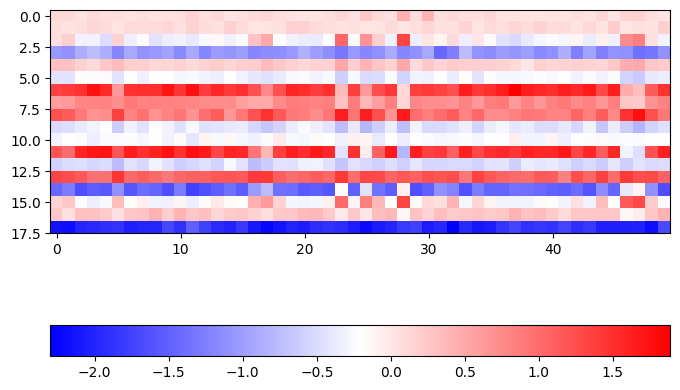

In [110]:
cond_X = cond_transformer(data_jets, data_lepton, data_met,
                                        data_boost_reco, mask_jets, 
                                        mask_lepton, mask_met, mask_boost_reco)
        
plt.figure(figsize=(8,8), dpi=100)
plt.imshow(cond_X[:50,:].T.detach().numpy(), cmap="bwr")
plt.colorbar(location="bottom")

In [37]:
for p in cond_transformer.parameters():
    print(p)
    


Parameter containing:
tensor([[ 0.0709, -0.1628,  0.0052,  0.1371, -0.1601],
        [-0.3670, -0.1786,  0.1169, -0.4195,  0.3495],
        [-0.3810,  0.4278, -0.1203,  0.0110,  0.0319],
        [ 0.3782,  0.0690,  0.1888,  0.3205, -0.4440],
        [ 0.0289, -0.4276, -0.0661, -0.1414, -0.3998],
        [ 0.1632, -0.0366, -0.2436,  0.1345,  0.0630],
        [-0.3873, -0.2475,  0.1913,  0.4144,  0.3779],
        [-0.4048,  0.3618, -0.4466, -0.1250, -0.3086],
        [ 0.3667,  0.4328,  0.0424, -0.2308, -0.3056],
        [ 0.3541,  0.2779, -0.1379,  0.4180, -0.2389],
        [-0.4309, -0.2922, -0.2151,  0.2041,  0.1368],
        [ 0.1878, -0.3563, -0.1920, -0.3627,  0.2515],
        [-0.4208,  0.3563, -0.2141,  0.1583, -0.2694],
        [-0.3447, -0.1483, -0.0461, -0.3081, -0.0944],
        [-0.1331, -0.1328, -0.0610,  0.1445,  0.3654]], dtype=torch.float32,
       requires_grad=True)
Parameter containing:
tensor([-0.4216,  0.3579, -0.3778,  0.2584, -0.2760,  0.3194,  0.1226,  0.4420,
  

In [38]:
(mask_partons, data_partons, 
        mask_lepton_partons, data_lepton_partons, 
        mask_boost_parton, data_boost_parton, 
        data_intermediate, data_intermediate_cartesian,
        data_ps,  mask_lepton, data_lepton, mask_jets,
        data_jets,mask_met, data_met,
        mask_boost_reco,data_boost_reco) =  data
    

cond_X = cond_transformer(data_jets, data_lepton, data_met,
                                        data_boost_reco, mask_jets, 
                                        mask_lepton, mask_met, mask_boost_reco)

In [103]:
ps_new = flow(cond_X).sample((50,))

In [68]:
data_ps.shape

torch.Size([512, 10])

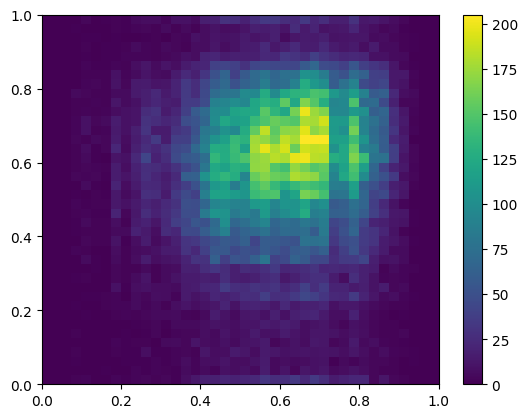

In [105]:
plt.hist2d(data_ps[:,-2:].unsqueeze(0).tile(50,1,1).flatten().numpy(), 
           ps_new[:,:,-2:].flatten().numpy(), 
           bins=40, range=((0,1),(0,1)));
plt.colorbar()

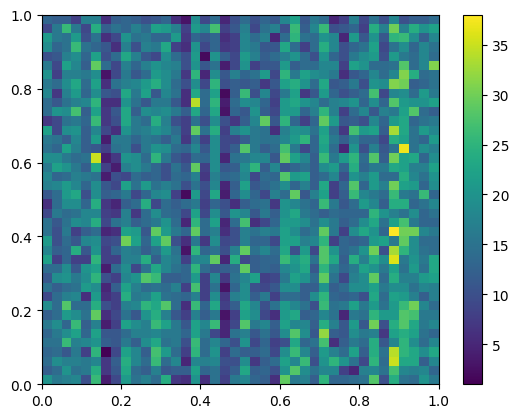

In [109]:
plt.hist2d(data_ps[:,7].unsqueeze(0).tile(50,1,1).flatten().numpy(), 
           ps_new[:,:,7].flatten().numpy(), 
           bins=40, range=((0,1),(0,1)));
plt.colorbar()

(array([  42.,   81.,  101.,  138.,  141.,  154.,  197.,  182.,  213.,
         221.,  247.,  244.,  251.,  238.,  278.,  288.,  263.,  280.,
         334.,  346.,  329.,  370.,  401.,  404.,  429.,  426.,  440.,
         429.,  504.,  523.,  542.,  578.,  604.,  615.,  656.,  680.,
         709.,  773.,  788.,  808.,  891.,  889.,  957., 1000., 1051.,
        1058., 1096., 1095., 1272., 1321., 1245., 1220., 1110., 1086.,
        1045.,  994.,  979.,  972.,  887.,  823.,  818.,  772.,  753.,
         701.,  646.,  647.,  597.,  614.,  492.,  543.,  495.,  509.,
         445.,  433.,  442.,  430.,  406.,  363.,  366.,  331.,  329.,
         302.,  342.,  253.,  288.,  263.,  270.,  232.,  248.,  184.,
         222.,  192.,  169.,  164.,  167.,  160.,  139.,   94.,   79.,
          42.]),
 array([-0.99332244, -0.97341674, -0.95351104, -0.93360535, -0.91369965,
        -0.89379395, -0.87388825, -0.85398255, -0.83407686, -0.81417116,
        -0.79426546, -0.77435976, -0.75445407, -0.734548

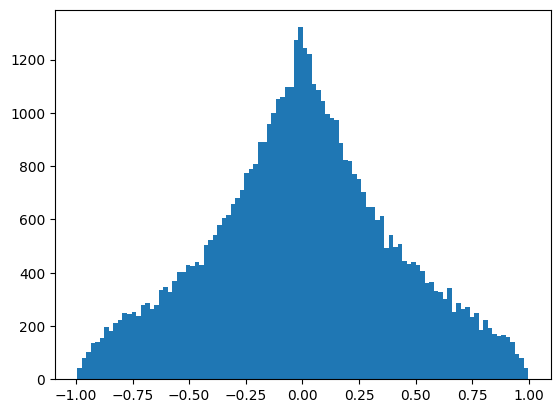

In [53]:
plt.hist((data_ps-ps_new).flatten(), bins=100)